# FashionMNIST

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Мы будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

In [43]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

In [44]:
import os
import wandb # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

In [45]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
  random.seed(seed) # фиксируем генератор случайных чисел
  os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
  np.random.seed(seed) # фиксируем генератор случайных чисел numpy
  torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
  torch.cuda.manual_seed(seed) 
    

Выпишем все классы для последующего использования. 

In [46]:
class CFG:

# Задаем параметры нашего эксперимента

  api = "b94b457348f7ca80a0feff1013713a4b363e30a1"# вписать свой API Wandb  
  project = "DL2" # вписать название эксперимента, который предварительно надо создать в Wandb
  entity = "renhas" # ввести свой логин
  num_epochs = 10 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 4 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
             "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"] # классы датасета
  wandb = True # флаг использования Wandb


In [47]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

Обратим внимание, что датасет поменялся, а значит поменлись среднее и стандартное отклонение, их необходимо посмотреть на официальной страничке датасета [ссылка](https://boscoj2008.github.io/customCNN/).

In [48]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.2859,), (0.3530,))])

Загружаем данные.

In [49]:
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_batch_size,
                                          shuffle=True, num_workers=CFG.num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=CFG.test_batch_size,
                                         shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

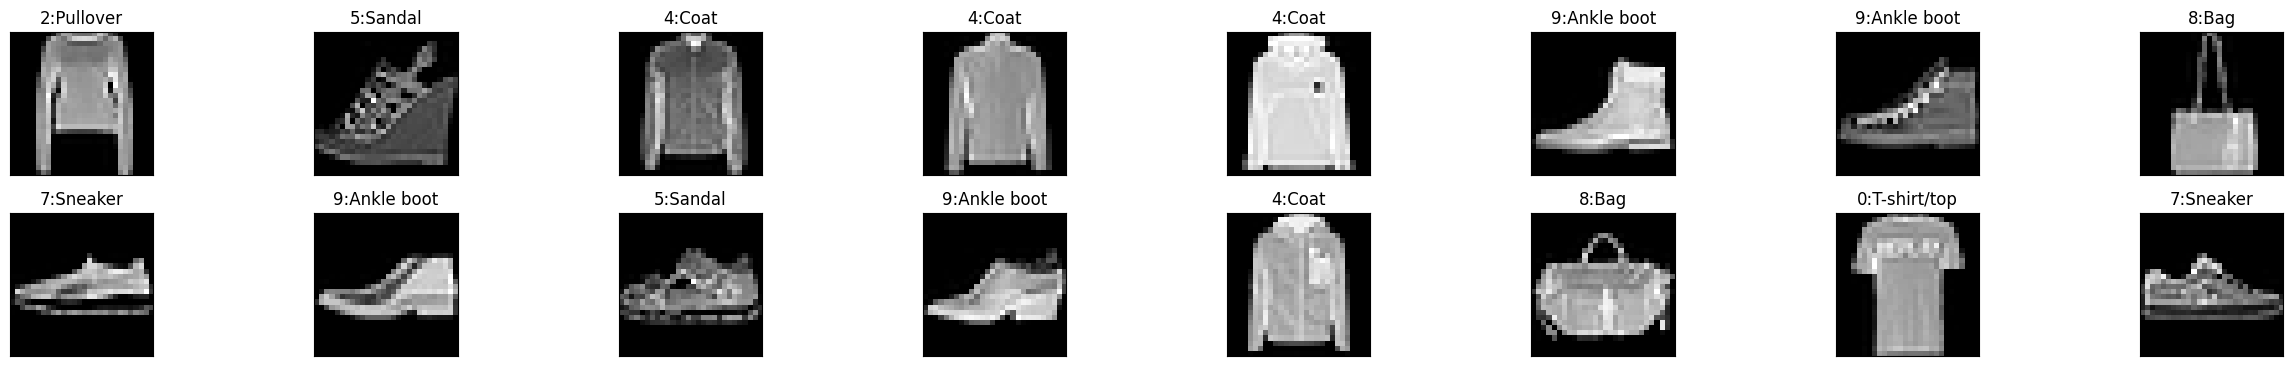

In [50]:
# отрисуем несколько картинок

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
  lbl = labels[idx]
  plt.subplot(2,8,idx+1)
  plt.tight_layout()
  plt.imshow(images[idx][0], cmap='gray', interpolation='none')
  plt.title(f"{lbl}:{CFG.classes[lbl]}")
  plt.xticks([])
  plt.yticks([])

In [51]:
images[0][0].shape

(28, 28)

Создаем полносвязаннную нейронную сеть. 

In [52]:
class My_Net(nn.Module):
  def __init__(self):
    super(My_Net, self).__init__()
    in_l = 28*28
    out_l = 10
    hidden_1 = 512
    hidden_2 = 256
    hidden_3 = 128
    self.net = torch.nn.Sequential(
                      torch.nn.Linear(in_l, hidden_1),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_1, hidden_2),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_2, hidden_3),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_3, out_l),
                      torch.nn.Softmax()
                    )
  def forward(self, x):
    x = x.view(-1, 28*28)
    x = self.net(x)
    return x

In [53]:
model_net = My_Net()
model_net = model_net.cuda() # переводим модель на GPU
print(model_net) # посмотрим на нашу модель

My_Net(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
    (7): Softmax(dim=None)
  )
)


In [54]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate) = 0.01
CFG.lr = 0.1
optimizer = torch.optim.SGD(model_net.parameters(), lr = CFG.lr)

In [55]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # обязательно переводим в режим обучения
    train_loss = 0
    correct = 0
    
    n_ex = len(train_loader)
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))
    
    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [56]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target) # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))
    
    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [57]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))
  
    use_cuda = torch.cuda.is_available() # проверяем доступность GPU 

    seed_everything(CFG.seed) # фиксируем сиды

    device = torch.device("cuda" if use_cuda else "cpu") # выделили устройство  
    
    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

In [58]:
CFG.wandb

True

In [30]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Tue May  2 15:19:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    30W /  70W |    621MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Запускаем обучение. Цель - получить на тесте значение accuracy не менее 88%.

In [213]:
main(model_net)

wandb: Currently logged in as: renhas. Use `wandb login --relogin` to force relogin



Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 938/938 [00:24<00:00, 38.99it/s]


Train set: Average loss: 1.7451, Accuracy: 65%


Test set: Average loss: 1.6501, Accuracy: 78%

Epoch: 2


100%|██████████| 938/938 [00:16<00:00, 57.45it/s]


Train set: Average loss: 1.5602, Accuracy: 80%


Test set: Average loss: 1.6266, Accuracy: 79%

Epoch: 3


100%|██████████| 938/938 [00:17<00:00, 54.57it/s]


Train set: Average loss: 1.6019, Accuracy: 81%


Test set: Average loss: 1.6355, Accuracy: 79%

Epoch: 4


100%|██████████| 938/938 [00:16<00:00, 57.81it/s]


Train set: Average loss: 1.8680, Accuracy: 82%


Test set: Average loss: 1.6222, Accuracy: 81%

Epoch: 5


100%|██████████| 938/938 [00:16<00:00, 57.94it/s]



Train set: Average loss: 1.6810, Accuracy: 82%
Test set: Average loss: 1.6172, Accuracy: 81%

Epoch: 6


100%|██████████| 938/938 [00:17<00:00, 53.61it/s]


Train set: Average loss: 1.5371, Accuracy: 83%


Test set: Average loss: 1.6091, Accuracy: 82%

Epoch: 7


100%|██████████| 938/938 [00:16<00:00, 56.18it/s]


Train set: Average loss: 1.5621, Accuracy: 83%


Test set: Average loss: 1.6159, Accuracy: 81%

Epoch: 8


100%|██████████| 938/938 [00:16<00:00, 57.62it/s]


Train set: Average loss: 1.5275, Accuracy: 83%


Test set: Average loss: 1.6035, Accuracy: 82%

Epoch: 9


100%|██████████| 938/938 [00:16<00:00, 55.42it/s]


Train set: Average loss: 1.6036, Accuracy: 83%


Test set: Average loss: 1.6060, Accuracy: 82%

Epoch: 10


100%|██████████| 938/938 [00:16<00:00, 56.57it/s]


Train set: Average loss: 1.7122, Accuracy: 84%


Test set: Average loss: 1.6217, Accuracy: 81%
Training is end!


Пробуем другие оптимизаторы.

In [231]:
optimizer = torch.optim.Adam(model_net.parameters())

In [232]:
main(model_net)

test_accuracy,▁▄▄▇▆▇▆▇█▆
test_loss,█▄▆▄▃▂▃▁▁▄
train_accuracy,▁▇▇▇▇█████
train_loss,▅▂▃█▄▁▂▁▃▅
test_accuracy,0.8079
test_loss,1.62174
train_accuracy,0.8368
train_loss,1.71217



Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 44.76it/s]


Train set: Average loss: 1.7743, Accuracy: 73%


Test set: Average loss: 1.6908, Accuracy: 73%

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 52.79it/s]


Train set: Average loss: 1.5503, Accuracy: 76%


Test set: Average loss: 1.6295, Accuracy: 79%

Epoch: 3


100%|██████████| 938/938 [00:17<00:00, 54.83it/s]


Train set: Average loss: 1.6795, Accuracy: 80%


Test set: Average loss: 1.6200, Accuracy: 80%

Epoch: 4


100%|██████████| 938/938 [00:16<00:00, 55.92it/s]


Train set: Average loss: 1.9299, Accuracy: 81%


Test set: Average loss: 1.6188, Accuracy: 81%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 54.60it/s]


Train set: Average loss: 1.6758, Accuracy: 82%


Test set: Average loss: 1.6277, Accuracy: 82%

Epoch: 6


100%|██████████| 938/938 [00:17<00:00, 53.65it/s]


Train set: Average loss: 1.5861, Accuracy: 81%


Test set: Average loss: 1.6171, Accuracy: 81%

Epoch: 7


100%|██████████| 938/938 [00:18<00:00, 49.68it/s]


Train set: Average loss: 1.5788, Accuracy: 81%


Test set: Average loss: 1.6491, Accuracy: 80%

Epoch: 8


100%|██████████| 938/938 [00:16<00:00, 55.37it/s]


Train set: Average loss: 1.6165, Accuracy: 80%


Test set: Average loss: 1.6151, Accuracy: 79%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 55.03it/s]


Train set: Average loss: 1.5862, Accuracy: 79%


Test set: Average loss: 1.6259, Accuracy: 79%

Epoch: 10


100%|██████████| 938/938 [00:18<00:00, 51.69it/s]


Train set: Average loss: 1.6799, Accuracy: 80%


Test set: Average loss: 1.6339, Accuracy: 81%
Training is end!


In [249]:
optimizer = torch.optim.AdamW(model_net.parameters())

In [250]:
main(model_net)

test_accuracy,▁▆▇▇█▇▆▆▆▇
test_loss,█▂▁▁▂▁▄▁▂▃
train_accuracy,▁▃▇███▇▆▆▇
train_loss,▅▁▃█▃▂▂▂▂▃
test_accuracy,0.8053
test_loss,1.63394
train_accuracy,0.80302
train_loss,1.6799



Epoch: 1


100%|██████████| 938/938 [00:23<00:00, 40.00it/s]


Train set: Average loss: 1.7018, Accuracy: 74%


Test set: Average loss: 1.6544, Accuracy: 79%

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 54.77it/s]


Train set: Average loss: 1.5557, Accuracy: 81%


Test set: Average loss: 1.6193, Accuracy: 80%

Epoch: 3


100%|██████████| 938/938 [00:16<00:00, 56.71it/s]


Train set: Average loss: 1.6153, Accuracy: 83%


Test set: Average loss: 1.6074, Accuracy: 82%

Epoch: 4


100%|██████████| 938/938 [00:16<00:00, 58.02it/s]


Train set: Average loss: 1.8679, Accuracy: 83%


Test set: Average loss: 1.6141, Accuracy: 83%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 54.84it/s]


Train set: Average loss: 1.7103, Accuracy: 83%


Test set: Average loss: 1.6027, Accuracy: 81%

Epoch: 6


100%|██████████| 938/938 [00:17<00:00, 54.22it/s]


Train set: Average loss: 1.4924, Accuracy: 83%


Test set: Average loss: 1.5825, Accuracy: 83%

Epoch: 7


100%|██████████| 938/938 [00:16<00:00, 57.00it/s]


Train set: Average loss: 1.6799, Accuracy: 83%


Test set: Average loss: 1.6285, Accuracy: 81%

Epoch: 8


100%|██████████| 938/938 [00:17<00:00, 55.03it/s]


Train set: Average loss: 1.6174, Accuracy: 82%


Test set: Average loss: 1.6417, Accuracy: 81%

Epoch: 9


100%|██████████| 938/938 [00:16<00:00, 56.90it/s]


Train set: Average loss: 1.5556, Accuracy: 82%


Test set: Average loss: 1.6152, Accuracy: 82%

Epoch: 10


100%|██████████| 938/938 [00:16<00:00, 57.17it/s]


Train set: Average loss: 1.6489, Accuracy: 82%


Test set: Average loss: 1.6044, Accuracy: 83%
Training is end!


При рассмотренных оптимизаторах особой разницы не заметно, поэтому оставим SGD.

Может стоить добавить еще пару слоев? Как уже говорилось ранее, deep learning - это пространство для экспериментов и творчества. Дерзайте!

In [31]:
class My_Net_v2(nn.Module):
  def __init__(self):
    super(My_Net_v2, self).__init__()
    in_l = 28*28
    out_l = 10
    hidden_1 = 522
    hidden_2 = 348
    hidden_3 = 232
    hidden_4 = 154
    hidden_5 = 103
    self.net = torch.nn.Sequential(
                      torch.nn.Linear(in_l, hidden_1),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_1, hidden_2),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_2, hidden_3),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_3, hidden_4),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_4, hidden_5),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_5, out_l),
                      torch.nn.Softmax()
                    )
  def forward(self, x):
    x = x.view(-1, 28*28)
    x = self.net(x)
    return x

In [34]:
model_net_2 = My_Net_v2()
model_net_2 = model_net_2.cuda()

In [35]:
optimizer = torch.optim.SGD(model_net_2.parameters(), lr = CFG.lr)

In [36]:
main(model_net_2)

wandb: Currently logged in as: renhas. Use `wandb login --relogin` to force relogin



Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 938/938 [00:17<00:00, 52.71it/s]


Train set: Average loss: 1.9492, Accuracy: 19%


Test set: Average loss: 1.9688, Accuracy: 49%

Epoch: 2


100%|██████████| 938/938 [00:18<00:00, 51.19it/s]


Train set: Average loss: 1.6940, Accuracy: 69%


Test set: Average loss: 1.6902, Accuracy: 73%

Epoch: 3


100%|██████████| 938/938 [00:16<00:00, 56.81it/s]


Train set: Average loss: 1.6528, Accuracy: 76%


Test set: Average loss: 1.6612, Accuracy: 75%

Epoch: 4


100%|██████████| 938/938 [00:16<00:00, 56.59it/s]



Train set: Average loss: 1.8844, Accuracy: 77%
Test set: Average loss: 1.6544, Accuracy: 76%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 52.19it/s]


Train set: Average loss: 1.7512, Accuracy: 78%


Test set: Average loss: 1.6434, Accuracy: 77%

Epoch: 6


100%|██████████| 938/938 [00:17<00:00, 53.14it/s]


Train set: Average loss: 1.6782, Accuracy: 79%


Test set: Average loss: 1.6265, Accuracy: 78%

Epoch: 7


100%|██████████| 938/938 [00:16<00:00, 55.48it/s]


Train set: Average loss: 1.6289, Accuracy: 80%


Test set: Average loss: 1.6348, Accuracy: 79%

Epoch: 8


100%|██████████| 938/938 [00:16<00:00, 56.01it/s]


Train set: Average loss: 1.6882, Accuracy: 80%


Test set: Average loss: 1.6230, Accuracy: 78%

Epoch: 9


100%|██████████| 938/938 [00:16<00:00, 57.43it/s]


Train set: Average loss: 1.7397, Accuracy: 80%


Test set: Average loss: 1.6351, Accuracy: 80%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 55.14it/s]


Train set: Average loss: 1.6152, Accuracy: 81%


Test set: Average loss: 1.6381, Accuracy: 77%
Training is end!


Увеличивание количества скрытых слоёв до 5 привело к ухудшению метрик

In [59]:
class My_Net_v3(nn.Module):
  def __init__(self):
    super(My_Net_v3, self).__init__()
    in_l = 28*28
    out_l = 10
    hidden_1 = 512
    hidden_2 = 256
    hidden_3 = 128
    self.net = torch.nn.Sequential(
                      torch.nn.Linear(in_l, hidden_1),
                      torch.nn.Sigmoid(),
                      torch.nn.Linear(hidden_1, hidden_2),
                      torch.nn.Sigmoid(),
                      torch.nn.Linear(hidden_2, hidden_3),
                      torch.nn.Sigmoid(),
                      torch.nn.Linear(hidden_3, out_l),
                      torch.nn.Softmax()
                    )
  def forward(self, x):
    x = x.view(-1, 28*28)
    x = self.net(x)
    return x

In [60]:
model_net_3 = My_Net_v3()
model_net_3 = model_net_3.cuda()

In [61]:
optimizer = torch.optim.SGD(model_net_3.parameters(), lr = CFG.lr)

In [63]:
main(model_net_3)

test_accuracy,▂▁▁▁▃▄▆▇██
test_loss,████▇▆▄▂▁▁
train_accuracy,▁▁▁▁▂▃▅▇██
train_loss,█████▆▅▁▁▁
test_accuracy,0.6193
test_loss,1.82713
train_accuracy,0.61893
train_loss,1.87916



Epoch: 1


100%|██████████| 938/938 [00:19<00:00, 49.30it/s]


Train set: Average loss: 1.8736, Accuracy: 63%


Test set: Average loss: 1.8165, Accuracy: 63%

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 54.38it/s]


Train set: Average loss: 1.7865, Accuracy: 63%


Test set: Average loss: 1.8095, Accuracy: 63%

Epoch: 3


100%|██████████| 938/938 [00:17<00:00, 54.52it/s]


Train set: Average loss: 1.7207, Accuracy: 64%


Test set: Average loss: 1.8052, Accuracy: 63%

Epoch: 4


100%|██████████| 938/938 [00:17<00:00, 53.94it/s]


Train set: Average loss: 2.0987, Accuracy: 64%


Test set: Average loss: 1.8016, Accuracy: 64%

Epoch: 5


100%|██████████| 938/938 [00:16<00:00, 55.23it/s]


Train set: Average loss: 1.8780, Accuracy: 64%


Test set: Average loss: 1.8003, Accuracy: 64%

Epoch: 6


100%|██████████| 938/938 [00:17<00:00, 52.36it/s]


Train set: Average loss: 1.8085, Accuracy: 64%


Test set: Average loss: 1.7956, Accuracy: 64%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 45.54it/s]


Train set: Average loss: 1.8044, Accuracy: 65%


Test set: Average loss: 1.7940, Accuracy: 64%

Epoch: 8


100%|██████████| 938/938 [00:23<00:00, 39.09it/s]


Train set: Average loss: 1.7387, Accuracy: 65%


Test set: Average loss: 1.7901, Accuracy: 64%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 54.23it/s]


Train set: Average loss: 1.8540, Accuracy: 65%


Test set: Average loss: 1.7891, Accuracy: 65%

Epoch: 10


100%|██████████| 938/938 [00:23<00:00, 39.29it/s]


Train set: Average loss: 1.8557, Accuracy: 65%


Test set: Average loss: 1.7878, Accuracy: 65%
Training is end!


Функция сигмоиды оказалась менее эффективной, чем ReLU

In [66]:
class My_Net_v4(nn.Module):
  def __init__(self):
    super(My_Net_v4, self).__init__()
    in_l = 28*28
    out_l = 10
    hidden_1 = 512
    hidden_2 = 256
    self.net = torch.nn.Sequential(
                      torch.nn.Linear(in_l, hidden_1),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_1, hidden_2),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_2, out_l),
                      torch.nn.Softmax()
                    )
  def forward(self, x):
    x = x.view(-1, 28*28)
    x = self.net(x)
    return x

In [67]:
model_net_4 = My_Net_v4()
model_net_4 = model_net_4.cuda()

In [69]:
optimizer = torch.optim.SGD(model_net_4.parameters(), lr = CFG.lr)

In [70]:
main(model_net_4)

test_accuracy,▁▂▄▅▆▇▇▇██
test_loss,█▆▅▄▄▃▃▂▁▁
train_accuracy,▁▂▄▅▅▆▇▇██
train_loss,▄▂▁█▄▃▃▁▃▄
test_accuracy,0.6454
test_loss,1.78777
train_accuracy,0.65145
train_loss,1.85574



Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 938/938 [00:17<00:00, 55.01it/s]


Train set: Average loss: 1.7126, Accuracy: 72%


Test set: Average loss: 1.6444, Accuracy: 79%

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 52.27it/s]


Train set: Average loss: 1.5660, Accuracy: 82%


Test set: Average loss: 1.6111, Accuracy: 83%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 46.40it/s]



Train set: Average loss: 1.5960, Accuracy: 85%
Test set: Average loss: 1.6032, Accuracy: 83%

Epoch: 4


100%|██████████| 938/938 [00:16<00:00, 55.60it/s]


Train set: Average loss: 1.8159, Accuracy: 86%


Test set: Average loss: 1.6033, Accuracy: 84%

Epoch: 5


100%|██████████| 938/938 [00:18<00:00, 51.81it/s]


Train set: Average loss: 1.6636, Accuracy: 86%


Test set: Average loss: 1.5855, Accuracy: 85%

Epoch: 6


100%|██████████| 938/938 [00:16<00:00, 55.41it/s]


Train set: Average loss: 1.4982, Accuracy: 87%


Test set: Average loss: 1.5797, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:16<00:00, 55.68it/s]


Train set: Average loss: 1.4978, Accuracy: 87%


Test set: Average loss: 1.5736, Accuracy: 85%

Epoch: 8


100%|██████████| 938/938 [00:17<00:00, 54.83it/s]


Train set: Average loss: 1.5295, Accuracy: 88%


Test set: Average loss: 1.5696, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 54.94it/s]


Train set: Average loss: 1.5651, Accuracy: 88%


Test set: Average loss: 1.5830, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:16<00:00, 55.47it/s]


Train set: Average loss: 1.6121, Accuracy: 88%


Test set: Average loss: 1.5784, Accuracy: 85%
Training is end!


Уменьшение количества слоёв дало чуть более хорошие результаты

In [101]:
class My_Net_final(nn.Module):
  def __init__(self):
    super(My_Net_final, self).__init__()
    in_l = 28*28
    out_l = 10
    hidden_1 = 256
    hidden_2 = 128
    self.net = torch.nn.Sequential(
                      torch.nn.Linear(in_l, hidden_1),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_1, hidden_2),
                      torch.nn.ReLU(),
                      torch.nn.Linear(hidden_2, out_l),
                      torch.nn.Softmax()
                    )
  def forward(self, x):
    x = x.view(-1, 28*28)
    x = self.net(x)
    return x

In [102]:
model_net_final = My_Net_final()
model_net_final = model_net_final.cuda()

In [108]:
optimizer = torch.optim.SGD(model_net_final.parameters(), lr = CFG.lr, momentum=0.5)
optimizer.zero_grad()

In [109]:
main(model_net_final)

test_accuracy,▂▃▅▄▅▇▇▁█▆
test_loss,▅▄▃▅▁▂▂█▁▃
train_accuracy,▁▂▃▃▅▅▆▇▇█
train_loss,▅▄▃█▆▁▂▃▂▇
test_accuracy,0.8675
test_loss,1.56558
train_accuracy,0.89308
train_loss,1.69525



Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 938/938 [00:16<00:00, 57.10it/s]


Train set: Average loss: 1.4925, Accuracy: 90%


Test set: Average loss: 1.5563, Accuracy: 87%

Epoch: 2


100%|██████████| 938/938 [00:16<00:00, 58.13it/s]


Train set: Average loss: 1.5236, Accuracy: 90%


Test set: Average loss: 1.5788, Accuracy: 87%

Epoch: 3


100%|██████████| 938/938 [00:18<00:00, 51.31it/s]


Train set: Average loss: 1.5237, Accuracy: 90%


Test set: Average loss: 1.5556, Accuracy: 88%

Epoch: 4


100%|██████████| 938/938 [00:17<00:00, 55.12it/s]


Train set: Average loss: 1.6874, Accuracy: 90%


Test set: Average loss: 1.5615, Accuracy: 88%

Epoch: 5


100%|██████████| 938/938 [00:16<00:00, 55.23it/s]


Train set: Average loss: 1.5960, Accuracy: 90%


Test set: Average loss: 1.5687, Accuracy: 88%

Epoch: 6


100%|██████████| 938/938 [00:16<00:00, 56.16it/s]


Train set: Average loss: 1.4613, Accuracy: 90%


Test set: Average loss: 1.5612, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:17<00:00, 53.54it/s]


Train set: Average loss: 1.5547, Accuracy: 90%


Test set: Average loss: 1.5633, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:16<00:00, 55.20it/s]


Train set: Average loss: 1.5676, Accuracy: 91%


Test set: Average loss: 1.5673, Accuracy: 87%

Epoch: 9


100%|██████████| 938/938 [00:16<00:00, 55.52it/s]


Train set: Average loss: 1.4928, Accuracy: 91%


Test set: Average loss: 1.5626, Accuracy: 87%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 54.41it/s]


Train set: Average loss: 1.5972, Accuracy: 91%


Test set: Average loss: 1.5589, Accuracy: 88%
Training is end!


Уменьшение количества нейронов и слоёв и изменение параметров оптимизатора позволили достигнуть точность в 88%